---
title: 'Breaching 1.5°C: Give me the odds'
subtitle: 'A companion notebook'
author:
  - name: J. Eduardo Vera-Valdés
    email: eduardo@math.aau.dk
    url: 'https://everval.github.io'
    affiliations:
      - name: Aalborg University
        department: Department of Mathematical Sciences
        country: Denmark
    orcid: 0000-0002-0337-8055
    corresponding: true
  - name: Olivia Kvist
    email: omtk@math.aau.dk
    affiliations:
      - name: Aalborg University
        department: Department of Mathematical Sciences
        country: Denmark
abstract: |
  This is a companion notebook to the article "Breaching 1.5°C: Give me the odds" by J. Eduardo Vera-Valdés and Olivia Kvist. It contains the code for the additional exercise considering the GISTEMP dataset. The code is written in Julia and it is organized into sections follow those of the replication notebook.
format:
  html:
    mainfont: Georgia, serif
    html-math-method: katex
    theme: litera
    code-fold: true
    title-block-banner: "#eef7ee"
#  typst:
#    mainfont: Computer Modern
#    fontsize: 12pt
#    papersize: a4
execute:
  enabled: true
  cache: true
  freeze: auto
engine: julia
#jupyter: julia-1.11
bibliography: library.bib
---

## 0. Load Packages

In [1]:
#| label: load-packages
#| echo: false
#| output: false
#| warning: false
#| include: false

using Pkg
Pkg.activate(pwd())
using Plots, Dates, CSV, DataFrames, LongMemory, Statistics, MarSwitching, Random
include("TrendEstimators.jl")
using .TrendEstimators

Random.seed!(123456)
theme(:ggplot2)

  Activating 

project at `~/Library/CloudStorage/OneDrive-AalborgUniversitet/Research/CLIMATE/Paris Goal/Odds-of-breaching-1.5C`


## 1. Load Data

### 1.1 Temperature

In [2]:
widetemp = CSV.read("data/GLB.Ts+dSST.csv", DataFrame)
rawtemp = TrendEstimators.longseries(widetemp)
T = size(rawtemp, 1);
dates = collect(Date(1880, 1, 1):Month(1):(Date(1880, 1, 1)+Dates.Month(T - 1)));
rawtemp = DataFrame("Dates" => dates, "Temperature" => rawtemp[:]);
first(rawtemp, 5)

5×2 DataFrame
 Row │ Dates       Temperature 
     │ Date        Float64     
─────┼─────────────────────────
   1 │ 1880-01-01        -0.2
   2 │ 1880-02-01        -0.26
   3 │ 1880-03-01        -0.09
   4 │ 1880-04-01        -0.17
   5 │ 1880-05-01        -0.1

### 1.2 El Niño

Loading the data and removing the missing values. They appear only at the beginning of the time series.

The data has been neatly collected by https://bmcnoldy.earth.miami.edu/tropics/oni/

In [3]:
rawnino = CSV.read("data/Nino_1854_2024.csv", DataFrame)
delete!(rawnino, rawnino.ONI .== -99.99)
first(rawnino, 5)

5×7 DataFrame
 Row │ YEAR   MON/MMM  NINO34_MEAN  NINO34_CLIM  NINO34_ANOM  ONI      PHASE   ⋯
     │ Int64  Int64    Float64      Float64      Float64      Float64  String1 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  1871        2        25.59        26.03        -0.45    -0.26  N       ⋯
   2 │  1871        3        26.66        26.55         0.11     0.08  N
   3 │  1871        4        27.57        26.99         0.58     0.31  N
   4 │  1871        5        27.4         27.16         0.24     0.36  N
   5 │  1871        6        27.17        26.93         0.24     0.26  N       ⋯

In [4]:
date_nino = Date.(rawnino[!, 1], rawnino[!, 2])
rawnino.Dates = date_nino
first(date_nino, 3)

3-element Vector{Date}:
 1871-02-01
 1871-03-01
 1871-04-01

### 1.3 Merging Data

Matching to first non-missing value of El Niño

In [5]:
tempnino = rawnino[rawnino.Dates.>=rawtemp.Dates[1], [:Dates, :ONI]]
tempnino[!, :Temp] = rawtemp.Temperature
T = length(tempnino.Dates)
last(tempnino, 5)

5×3 DataFrame
 Row │ Dates       ONI      Temp    
     │ Date        Float64  Float64 
─────┼──────────────────────────────
   1 │ 2024-05-01     0.4      1.16
   2 │ 2024-06-01     0.15     1.24
   3 │ 2024-07-01     0.04     1.2
   4 │ 2024-08-01    -0.11     1.3
   5 │ 2024-09-01    -0.22     1.23

### 1.4 Rebaseline to pre-industrial levels (1850-1900)

In [6]:
newbaseline = mean(tempnino[(tempnino.Dates.>Date(1850, 1, 1)).&(tempnino.Dates.<Date(1900, 1, 1)), :Temp]);
tempnino.Temp = tempnino.Temp .- newbaseline;

### 1.5 Temperature plots, pre-industrial baseline against 1951-1980 baseline

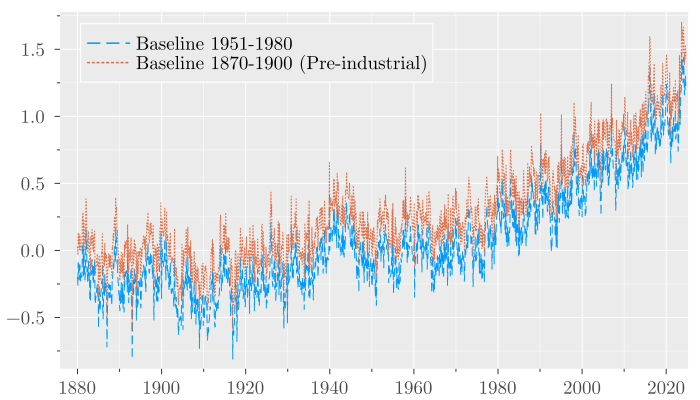

In [7]:
#| label: fig-temp-baselinesgistemp
#| fig-cap: "Temperature Anomalies (°C) [GISTEMP; @GISTEMPTeam2020]"

theme(:ggplot2)
plot(tempnino.Dates, [rawtemp.Temperature tempnino.Temp], label=["Baseline 1951-1980" "Baseline 1870-1900 (Pre-industrial)"], xlabel="", ylabel="", title = "", linewidth=[1 1.1], linestyle=[:dash :dot], xticks=(tempnino.Dates[1:240:end], Dates.format.(tempnino.Dates[1:240:end], "Y")), xlims=(Date(1880, 1, 1), Date(2021, 1, 1)))
plot!(size=(700, 400), fontfamily="Computer Modern", legendfontsize=12, tickfontsize=12, titlefontfamily="Computer Modern", legendfontfamily="Computer Modern", tickfontfamily="Computer Modern", ylabelfontsize=12, xlabelfontsize=14, titlefontsize=16, xlabel="", ylabel="")


In [8]:
maximum(rawtemp.Temperature)

1.48

## 2. First Look at the Data

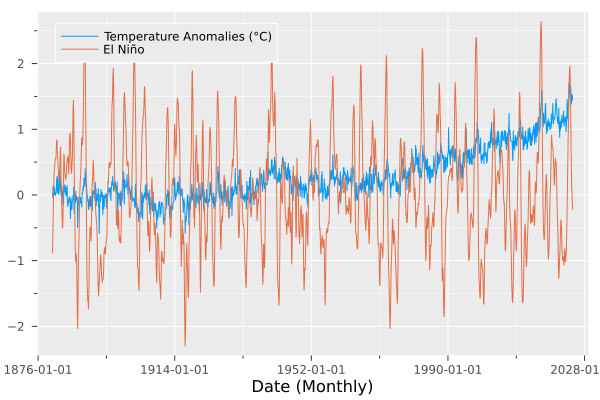

In [9]:
#| label: fig-raw-temp-nino-gistemp
#| fig-cap: 'Raw Temperature Anomalies [GISTEMP; @GISTEMPTeam2020]'
plot(tempnino.Dates, [tempnino.Temp tempnino.ONI], label=["Temperature Anomalies (°C)" "El Niño"], xlabel="Date (Monthly)", ylabel="", legend=:topleft)

## 3. Markov Switching Model

Two specifications are considered: one with 3 regimes (El Niño, La Niña, and Neutral) and one with 7 regimes (Very Strong El Niño, Strong El Niño, Moderate El Niño, Neutral, Moderate La Niña, Strong La Niña, and Very Strong La Niña).

In [10]:
nino_model3 = MSModel(tempnino[!, :ONI], 3);
summary_msm(nino_model3);

Markov Switching Model with 3 regimes


# of observations:         1737 AIC:                      2245.764


# of estimated parameters:   12 BIC:                      2311.283
Error distribution:    Gaussian Instant. adj. R^2:          0.7192
Loglikelihood:          -1110.9 Step-ahead adj. R^2:        0.6079
-----------------------------------------------------------------
------------------------------
Summary of regime 1: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |     1.146  |       0.036  |   31.954  |    < 1e-3  
σ            |     0.487  |       0.013  |   37.037  |    < 1e-3  


-------------------------------------------------------------------
Expected regime duration: 10.00 periods
-------------------------------------------------------------------
------------------------------
Summary of regime 2: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |    -0.792  |       0.023  |  -34.854  |    < 1e-3  
σ            |     0.408  |       0.009  |   43.253  |    < 1e-3  
-------------------------------------------------------------------
Expected regime duration: 15.72 periods
-------------------------------------------------------------------
------------------------------
Summary of regime 3: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |     0.148  |       0.024  |    6.147  |    < 1e-3  
σ          

-------------------------------------------------------------------
Expected regime duration: 8.03 periods
-------------------------------------------------------------------
left-stochastic transition matrix: 
          | regime 1   | regime 2   | regime 3
----------------------------------------------------
 regime 1 |   90.002%  |      0.0%  |    5.942%  |
 regime 2 |      0.0%  |   93.638%  |    6.516%  |
 regime 3 |    9.998%  |    6.362%  |   87.542%  |


In [11]:
nino_model7 = MSModel(tempnino[!, :ONI], 7);
summary_msm(nino_model7);

Markov Switching Model with 7 regimes


# of observations:         1737 AIC:                       725.273
# of estimated parameters:   56 BIC:                      1031.029
Error distribution:    Gaussian Instant. adj. R^2:          0.9131
Loglikelihood:           -306.6 Step-ahead adj. R^2:        0.8233
-----------------------------------------------------------------
------------------------------
Summary of regime 1: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |    -0.015  |       0.009  |   -1.625  |     0.104  
σ            |     0.099  |       0.013  |    7.679  |    < 1e-3  


-------------------------------------------------------------------
Expected regime duration: 2.19 periods
-------------------------------------------------------------------
------------------------------
Summary of regime 2: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |    -1.282  |       0.027  |  -48.158  |    < 1e-3  


σ            |     0.283  |       0.009  |   30.554  |    < 1e-3  
-------------------------------------------------------------------
Expected regime duration: 7.08 periods
-------------------------------------------------------------------
------------------------------
Summary of regime 3: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |     1.433  |       0.042  |   34.476  |    < 1e-3  
σ            |     0.414  |       0.011  |   36.377  |    < 1e-3  


-------------------------------------------------------------------
Expected regime duration: 7.69 periods
-------------------------------------------------------------------
------------------------------
Summary of regime 4: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |     0.308  |       0.016  |   18.945  |    < 1e-3  


σ            |     0.105  |       0.016  |     6.58  |    < 1e-3  
-------------------------------------------------------------------
Expected regime duration: 2.66 periods
-------------------------------------------------------------------
------------------------------
Summary of regime 5: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |    -0.728  |       0.041  |  -17.749  |    < 1e-3  
σ            |     0.135  |       0.015  |     8.99  |    < 1e-3  


-------------------------------------------------------------------
Expected regime duration: 3.23 periods
-------------------------------------------------------------------
------------------------------
Summary of regime 6: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |    -0.351  |       0.019  |  -18.902  |    < 1e-3  


σ            |     0.118  |       0.015  |    7.934  |    < 1e-3  
-------------------------------------------------------------------
Expected regime duration: 2.97 periods
-------------------------------------------------------------------
------------------------------
Summary of regime 7: 
------------------------------
Coefficient  |  Estimate  |  Std. Error  |  z value  |  Pr(>|z|) 
-------------------------------------------------------------------
β_0          |     0.677  |       0.049  |   13.945  |    < 1e-3  
σ            |     0.162  |       0.013  |   12.701  |    < 1e-3  


-------------------------------------------------------------------
Expected regime duration: 3.19 periods
-------------------------------------------------------------------
left-stochastic transition matrix: 
          | regime 1   | regime 2   | regime 3   | regime 4   | regime 5   | regime 6   | regime 7
--------------------------------------------------------------------------------------------------------
 regime 1 |   54.362%  |      0.0%  |      0.0%  |   17.573%  |      0.0%  |   17.654%  |     2.76%  |
 regime 2 |      0.0%  |   85.879%  |      0.0%  |      0.0%  |   12.095%  |      0.0%  |      0.0%  |
 regime 3 |      0.0%  |      0.0%  |   87.001%  |      0.0%  |      0.0%  |      0.0%  |   11.513%  |
 regime 4 |   22.099%  |      0.0%  |      0.0%  |   62.472%  |      0.0%  |    0.392%  |    17.06%  |
 regime 5 |    1.753%  |   14.121%  |      0.0%  |      0.0%  |   69.053%  |   14.341%  |      0.0%  |
 regime 6 |   19.883%  |      0.0%  |      0.0%  |    1.153%  |   17.5

Looking at the BIC, the 7-regime model is preferred.
Hence, we continue with the 7-regime model.

## 4. Trend Model

### Fitting the trend model

#### One example, quadratic trend

Fitting the quadratic trend model to the temperature anomalies and to the temperature anomalies with the El Niño index as an exogenous variable.

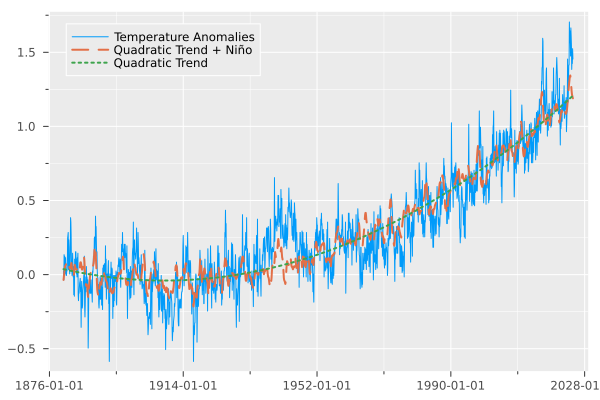

In [12]:
qmodel_exo = TrendEstimators.quad_trend_est(tempnino.Temp, tempnino.ONI)
qmodel = TrendEstimators.quad_trend_est(tempnino.Temp)
plot(tempnino.Dates, tempnino.Temp, linewidth=1, label="Temperature Anomalies", xlabel="", ylabel="", legend=:topleft)
plot!(tempnino.Dates, qmodel_exo.Yfit, linestyle=:dash, linewidth=2, label="Quadratic Trend + Niño", color=2)
plot!(tempnino.Dates, qmodel.Yfit, linestyle=:dot, linewidth=2, label="Quadratic Trend", color=3)

Forecasting the quadratic trend model in two ways: only the quadratic trend and the quadratic trend with the long memory component.

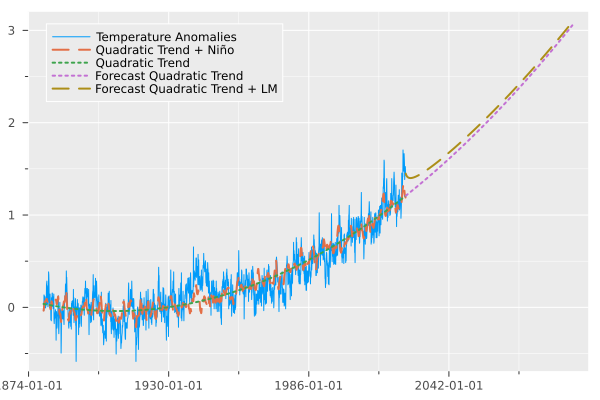

In [13]:
h = 800
date_for = collect((tempnino.Dates[1]+Dates.Month(T)):Month(1):(tempnino.Dates[1]+Dates.Month(T - 1)+Dates.Month(h)));
qmodel_forecast = TrendEstimators.quad_trend_forecast(qmodel, h);
plot!(date_for, qmodel_forecast.Yforecastmean, linestyle=:dot, linewidth=2, label="Forecast Quadratic Trend", color=4)
plot!(date_for, qmodel_forecast.Yforecasterr, linestyle=:dash, linewidth=2, label="Forecast Quadratic Trend + LM", color=5)
#plot!(xlims=(Date(2016,1,1),Date(2050,1,1)))

Final forecasting adding the exogenous variable El Niño.

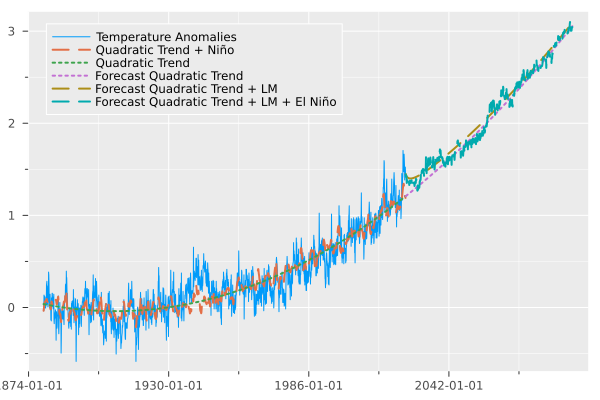

In [14]:
simul_nino = generate_msm(nino_model7, h)[1]
qmodel_exo_forecast = TrendEstimators.quad_trend_forecast(qmodel_exo, h, simul_nino)
plot!(date_for, qmodel_exo_forecast.Yforecasterr, linestyle=:dash, linewidth=2, label="Forecast Quadratic Trend + LM + El Niño", color=6)

### A second example, broken linear trend

Fitting the broken linear trend model to the temperature anomalies and to the temperature anomalies with the El Niño index as an exogenous variable.

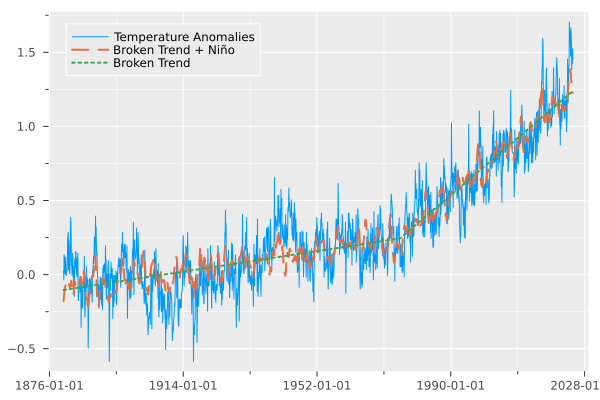

In [15]:
bmodel = TrendEstimators.broken_trend_est(tempnino.Temp)
bmodel_exo = TrendEstimators.broken_trend_est(tempnino.Temp, tempnino.ONI)
plot(tempnino.Dates, tempnino.Temp, linewidth=1, label="Temperature Anomalies", xlabel="", ylabel="", legend=:topleft)
plot!(tempnino.Dates, bmodel_exo.Yfit, linestyle=:dash, linewidth=2, label="Broken Trend + Niño", color=2)
plot!(tempnino.Dates, bmodel.Yfit, linestyle=:dot, linewidth=2, label="Broken Trend", color=3)

Forecasting the broken linear trend model in two ways: only the broken linear trend and the broken linear trend with the long memory component.

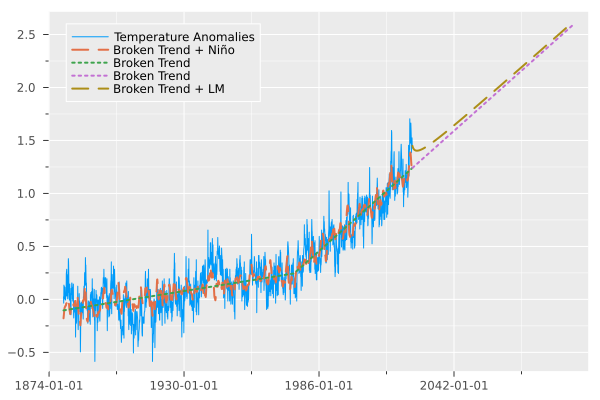

In [16]:
date_for = collect((tempnino.Dates[1]+Dates.Month(T)):Month(1):(tempnino.Dates[1]+Dates.Month(T - 1)+Dates.Month(h)));
bmodel_forecast = TrendEstimators.broken_trend_forecast(bmodel, h);
plot!(date_for, bmodel_forecast.Yforecastmean, linestyle=:dot, linewidth=2, label="Broken Trend", color=4)
plot!(date_for, bmodel_forecast.Yforecasterr, linestyle=:dash, linewidth=2, label="Broken Trend + LM", color=5)

Final forecasting adding the exogenous variable El Niño.

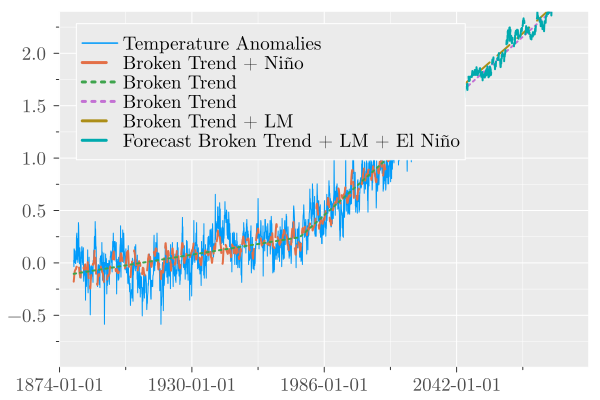

In [17]:
simul_nino = generate_msm(nino_model7, h)[1]
bmodel_exo_forecast = TrendEstimators.broken_trend_forecast(bmodel_exo, h, simul_nino)
plot!(date_for, bmodel_exo_forecast.Yforecasterr, linestyle=:dash, linewidth=2, label="Forecast Broken Trend + LM + El Niño", color=6)
plot!(fontfamily="Computer Modern", legendfontsize=12, tickfontsize=12, titlefontfamily="Computer Modern", legendfontfamily="Computer Modern", tickfontfamily="Computer Modern", ylabelfontsize=12, xlabelfontsize=12, titlefontsize=16, xlabel="", ylabel="", ylims=(-0.9, 2.3))

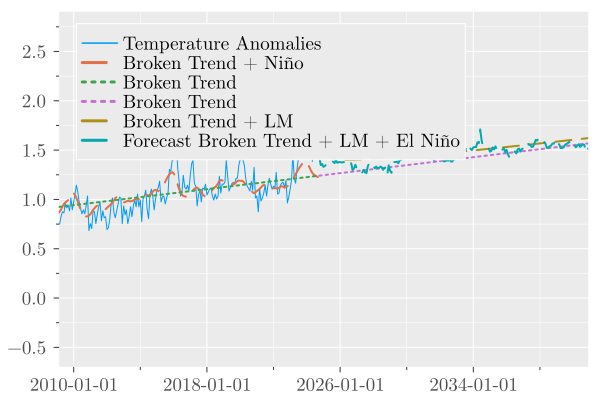

In [18]:
plot!(fontfamily="Computer Modern", legendfontsize=12, tickfontsize=12, titlefontfamily="Computer Modern", legendfontfamily="Computer Modern", tickfontfamily="Computer Modern", ylabelfontsize=12, xlabelfontsize=12, titlefontsize=16, xlabel="", ylabel="", ylims=(-0.6, 2.8), xlims=(Date(2010, 1, 1), Date(2040, 1, 1)))

### Selecting the best model

In [19]:
thisseries = tempnino.Temp;
TrendEstimators.select_trend_model(TrendEstimators.trend_est(thisseries, tempnino.ONI), TrendEstimators.quad_trend_est(thisseries, tempnino.ONI), TrendEstimators.broken_trend_est(thisseries, tempnino.ONI))

("break", (β = [-0.10845353786271886, 0.00031017621216602797, 0.0014007615609357938, 0.0802494248222951], σ² = 0.020828829478738424, break_point = 1156, rss = 36.09636148665369, aic = -6720.656322648539, bic = -6698.816663583574, betavar = [6.616202189169194e-5 -7.80026251038521e-8 1.3992355489884193e-7 -5.124839398067918e-7; -7.800262510385208e-8 1.2133658952891322e-10 -2.819381047333273e-10 3.09733692790573e-10; 1.399235548988419e-7 -2.8193810473332736e-10 1.079521644592358e-9 4.6172650805655123e-10; -5.124839398067916e-7 3.0973369279057256e-10 4.6172650805655273e-10 1.7109810785350542e-5], res = [0.20309618882750582, 0.1243286449062119, 0.27556110098491804, 0.1703736030778405, 0.22882850739055316, 0.08604849222814451, 0.10092335052664077, 0.18740319732158295, 0.13147556137185623, 0.056350419670352515  …  0.19827789106618354, 0.10020935551287158, 0.31257324518645846, 0.2889496061011596, 0.25174592100164506, 0.11491230492345439, 0.21326372335592647, 0.1803802223132771, 0.2907066982635

## 5. Forecasting paths

There is only one realization of the GISTEMP dataset, so we add the data uncertainty by sampling from the distribution of the estimated parameters.

In [20]:
nsim = 1000
matforecasts = zeros(h, nsim)
uncertainty = 1.96 

thisseries = tempnino.Temp

test = TrendEstimators.trend_est(thisseries, tempnino.ONI)
qtest = TrendEstimators.quad_trend_est(thisseries, tempnino.ONI)
btest = TrendEstimators.broken_trend_est(thisseries, tempnino.ONI)

model_selection = TrendEstimators.select_trend_model(test, qtest, btest)

for jj = 1:nsim

    simul_nino = generate_msm(nino_model7, h)[1]

    if model_selection[1] == "trend"
        matforecasts[:, jj] = TrendEstimators.trend_forecast(test, h, simul_nino, uncertainty).Yforecasterr
    elseif model_selection[1] == "quad"
        matforecasts[:, jj] = TrendEstimators.quad_trend_forecast(qtest, h, simul_nino, uncertainty).Yforecasterr
    elseif model_selection[1] == "break"
        matforecasts[:, jj] = TrendEstimators.broken_trend_forecast(btest, h, simul_nino, uncertainty).Yforecasterr
    else
        @warn "No model selected"
    end

end

### Plotting the forecasts

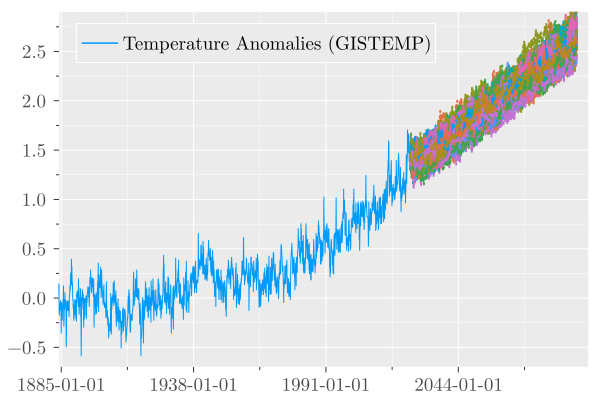

In [21]:
#| label: fig-paths-GISTEMP-All-Realizations
#| fig-cap: 'Simulated forecast paths for GISTEMP temperature anomalies.'

 p1 = plot(tempnino.Dates, tempnino.Temp, linewidth=1, label="Temperature Anomalies (GISTEMP)", xlabel="", ylabel="", legend=:topleft)
 plot!(date_for, matforecasts[:,rand(1:nsim,100)], linestyle=:dot, linewidth=2, label="")
 plot!(fontfamily="Computer Modern", legendfontsize=12, tickfontsize=12, titlefontfamily="Computer Modern", legendfontfamily="Computer Modern", tickfontfamily="Computer Modern", ylabelfontsize=12, xlabelfontsize=12, titlefontsize=16, xlabel="", ylabel="", ylims=(-0.6, 2.8), xlims=(Date(1890, 1, 1), Date(2090, 1, 1)))

## 6. Estimating the probability of exceeding 1.5°C 
### Using the middle point of the first 20 years period where the mean temperature exceeds 1.5°C

In [22]:
inicio = T - 119 # 10 years starting 2004
fin = T + h - 120 # 10 years

datejoin = collect((tempnino.Dates[inicio]):Month(1):date_for[h-120])
meantemp = tempnino[inicio:T, :Temp]
dummies = zeros(h, nsim)

for jj = 1:nsim
    completo = [meantemp; matforecasts[:, jj]]
    for ii = 120:h
        dummies[ii, jj] = mean(completo[ii-119:ii+120])
    end
end

pa15 = mean(dummies[:, :] .>= 1.5, dims=2);
pa20 = mean(dummies[:, :] .>= 2, dims=2);

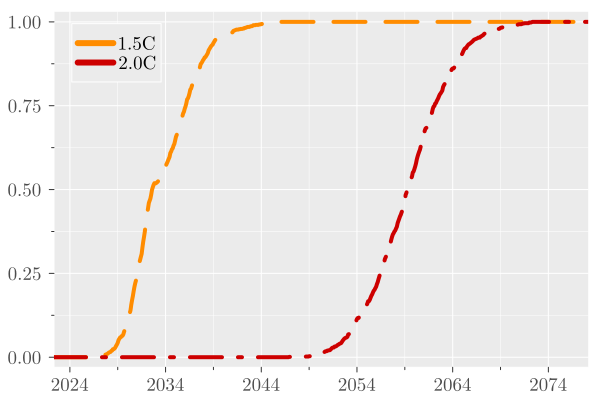

In [23]:
#| label: fig-simulation-dist-gistemp
#| fig-cap: Proportion of scenarios that breach the 1.5°C and 2°C thresholds for the GISTEMP temperature anomalies for each month. The figure considers 1000 scenarios, each based on the best-fitting model for each realization, with five simulations for El Niño as an exogenous variable each.

plot(datejoin, pa15, label="1.5C", color=:darkorange, legend=:topleft, xlims=(datejoin[120], datejoin[end-48]), xticks=(datejoin[1:120:end], Dates.format.(datejoin[1:120:end], "Y")), linewidth=4, linestyle=:dash)
plot!(datejoin, pa20, label="2.0C", color=:red3, linewidth=4, linestyle=:dashdot)
plot!(fontfamily="Computer Modern", legendfontsize=12, tickfontsize=12, titlefontfamily="Computer Modern", legendfontfamily="Computer Modern", tickfontfamily="Computer Modern", ylabelfontsize=12, xlabelfontsize=12, titlefontsize=16, xlabel="", ylabel="", ylims=(0, 1))

In [24]:
results_probabilities = DataFrame("Probability level and period" => String[], "1.5°C Threshold" => Date[], "2°C Threshold" => Date[])

push!(results_probabilities, ["Above 0%, 20-years avg.", datejoin[findfirst(pa15 .> 0)], datejoin[findfirst(pa20 .> 0)]])
push!(results_probabilities, ["Above 50%, 20-years avg.", datejoin[findfirst(pa15 .>= 0.5)], datejoin[findfirst(pa20 .>= 0.5)]])
push!(results_probabilities, ["Above 99%, 20-years avg.", datejoin[findfirst(pa15 .>= 0.99)], datejoin[findfirst(pa20 .>= 0.99)]])

3×3 DataFrame
 Row │ Probability level and period  1.5°C Threshold  2°C Threshold 
     │ String                        Date             Date          
─────┼──────────────────────────────────────────────────────────────
   1 │ Above 0%, 20-years avg.       2027-05-01       2047-09-01
   2 │ Above 50%, 20-years avg.      2033-06-01       2060-01-01
   3 │ Above 99%, 20-years avg.      2043-12-01       2071-02-01

### Using the middle point of the first 30 years period where the mean temperature exceeds 1.5°C

In [25]:
inicio30 = T - 179 # 15 years starting 2004
fin30 = T + h - 180 # 15 years
datejoin30 = collect((tempnino.Dates[inicio30]):Month(1):date_for[h-180])
meantemp30 = tempnino[inicio30:T, :Temp]
dummies30 = zeros(h, nsim)

for jj = 1:nsim
    completo = [meantemp30; matforecasts[:, jj]]
    for ii = 180:h
        dummies30[ii, jj] = mean(completo[ii-179:ii+180])
    end
end

pa15_30 = mean(dummies30[:, :] .>= 1.5, dims=2);
pa20_30 = mean(dummies30[:, :] .>= 2, dims=2);

Updating table with the results for the 30 years period.

In [26]:
push!(results_probabilities, ["Above 0%, 30-years avg.", datejoin[findfirst(pa15_30 .> 0)], datejoin[findfirst(pa20_30 .> 0)]])
push!(results_probabilities, ["Above 50%, 30-years avg.", datejoin[findfirst(pa15_30 .>= 0.5)], datejoin[findfirst(pa20_30 .>= 0.5)]])
push!(results_probabilities, ["Above 99%, 30-years avg.", datejoin[findfirst(pa15_30 .>= 0.99)], datejoin[findfirst(pa20_30 .>= 0.99)]])

6×3 DataFrame
 Row │ Probability level and period  1.5°C Threshold  2°C Threshold 
     │ String                        Date             Date          
─────┼──────────────────────────────────────────────────────────────
   1 │ Above 0%, 20-years avg.       2027-05-01       2047-09-01
   2 │ Above 50%, 20-years avg.      2033-06-01       2060-01-01
   3 │ Above 99%, 20-years avg.      2043-12-01       2071-02-01
   4 │ Above 0%, 30-years avg.       2033-02-01       2052-09-01
   5 │ Above 50%, 30-years avg.      2039-06-01       2065-01-01
   6 │ Above 99%, 30-years avg.      2048-10-01       2075-12-01

Saving the results to a csv file.

In [27]:
CSV.write("tables/ResultsGISTEMP.csv", results_probabilities)

"tables/ResultsGISTEMP.csv"

Full table with the results.

In [28]:
#| label: tbl-results-GISTEMP
#| tbl-cap: Months to breach the 1.5°C and 2°C thresholds for the GISTEMP temperature anomalies at a given probability level. 
#| tbl-pos: bottom

results_probabilities

6×3 DataFrame
 Row │ Probability level and period  1.5°C Threshold  2°C Threshold 
     │ String                        Date             Date          
─────┼──────────────────────────────────────────────────────────────
   1 │ Above 0%, 20-years avg.       2027-05-01       2047-09-01
   2 │ Above 50%, 20-years avg.      2033-06-01       2060-01-01
   3 │ Above 99%, 20-years avg.      2043-12-01       2071-02-01
   4 │ Above 0%, 30-years avg.       2033-02-01       2052-09-01
   5 │ Above 50%, 30-years avg.      2039-06-01       2065-01-01
   6 │ Above 99%, 30-years avg.      2048-10-01       2075-12-01